# Accessing correlation matrices and model derivatives

The results of a fit consist of best-fit parameter values and uncertainties, and residuals; these are conventional data products from pulsar timing. Additional information can be useful though: we can describe the correlations between model parameters in a matrix, and we can compute the derivatives of the residuals with respect to the model parameters. Both of these additional pieces of information can be obtained from a Fitter object in PINT; this notebook will demonstrate how to do this efficiently.

In [1]:
import contextlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.stats

import matplotlib.pyplot as plt
from astropy.visualization import quantity_support

import pint.fitter
import pint.models
import pint.toa

pint.logging.setup(level="INFO")
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fd066e1dfd0>

In [2]:
parfile = Path(pint.config.examplefile("NGC6440E.par"))
timfile = Path(pint.config.examplefile("NGC6440E.tim"))
assert parfile.exists()
assert timfile.exists()

In [3]:
m, t = pint.models.get_model_and_toas(parfile, timfile)

## Extracting the parameter covariance matrix

Unfortunately, parameter correlation matrices are not stored when `.par` files are recorded, only the individual parameter uncertainties. In PINT, the machinery for computing these matrices resides in `Fitter` objects. We will therefore construct one and carry out a fit - but we will take zero steps, so that the fit doesn't change the solution (and it runs fairly quickly!).

Normally you should probably actually do something if the model isn't converged! Specifically, the covariance matrix probably isn't very meaningful if you're not at a best-fit set of parameters. Unfortunately, with `maxiter=0` you will always get an exception claiming that the fitter hasn't converged.

In [4]:
fitter = pint.fitter.Fitter.auto(t, m)

with contextlib.suppress(pint.fitter.MaxiterReached):
    fitter.fit_toas(maxiter=0)

You can get a human-readable version of the parameter correlation matrix:

In [5]:
fitter.parameter_correlation_matrix


Parameter correlation matrix:
         RAJ   DECJ    F0     F1     DM   
  RAJ    1.000
 DECJ   -0.072  1.000
  F0    -0.087  0.247  1.000
  F1     0.294 -0.344 -0.798  1.000
  DM    -0.005  0.065  0.007  0.058  1.000


If you want a machine-readable version:

In [6]:
fitter.parameter_correlation_matrix.labels

[[('Offset', (0, 1, Unit(dimensionless))),
  ('RAJ', (1, 2, Unit("1 / (Hz hourangle)"))),
  ('DECJ', (2, 3, Unit("1 / (Hz deg)"))),
  ('F0', (3, 4, Unit("1 / Hz2"))),
  ('F1', (4, 5, Unit("s / Hz2"))),
  ('DM', (5, 6, Unit("cm3 / (Hz pc)")))],
 [('Offset', (0, 1, Unit(dimensionless))),
  ('RAJ', (1, 2, Unit("1 / (Hz hourangle)"))),
  ('DECJ', (2, 3, Unit("1 / (Hz deg)"))),
  ('F0', (3, 4, Unit("1 / Hz2"))),
  ('F1', (4, 5, Unit("s / Hz2"))),
  ('DM', (5, 6, Unit("cm3 / (Hz pc)")))]]

In [7]:
fitter.parameter_correlation_matrix.matrix

array([[ 1.        ,  0.02479064, -0.05713427, -0.00909425, -0.01942478,
        -0.99531251],
       [ 0.02479064,  1.        , -0.07222405, -0.08730079,  0.29426893,
        -0.00496847],
       [-0.05713427, -0.07222405,  1.        ,  0.24713231, -0.34386087,
         0.0648164 ],
       [-0.00909425, -0.08730079,  0.24713231,  1.        , -0.79767086,
         0.00674302],
       [-0.01942478,  0.29426893, -0.34386087, -0.79767086,  1.        ,
         0.05755779],
       [-0.99531251, -0.00496847,  0.0648164 ,  0.00674302,  0.05755779,
         1.        ]])

Be warned: the labels here are not necessarily in the same order as `fo.model.free_params`. Also, if the model includes red noise parameters, there may be more rows and columns than labels in the parameter covariance matrix. These unlabelled rows and columns will always be at the end. Let's check that there aren't surprises waiting for this pulsar.

Note also that correlation matrices are unitless, so the units recorded in the `.labels` attribute are wrong.

Even if there are no noise component entries, the correlation matrix includes a row and column for the non-parameter `Offset`. This arises because internally PINT fits allow for a constant offset in phase, but custom in pulsar timing is to report mean-subtracted residuals and ignore the absolute phase.

In [8]:
print(f"Model free parameters: {len(fitter.model.free_params)}")
print(
    f"Correlation matrix labels: {len(fitter.parameter_correlation_matrix.labels[0])}"
)
print(f"Correlation matrix shape: {fitter.parameter_correlation_matrix.shape}")

Model free parameters: 5
Correlation matrix labels: 6
Correlation matrix shape: (6, 6)


Let's extract the correlation matrix in a more convenient form. This requires some fancy indexing to rearrange the rows and columns as needed.

In [9]:
pint_correlations = fitter.parameter_correlation_matrix

params = fitter.model.free_params
corr_labels = [label for label, _ in pint_correlations.labels[0]]
ix = [corr_labels.index(p) for p in params]

raw_correlation = pint_correlations.matrix
assert np.allclose(raw_correlation, raw_correlation.T)
raw_correlation = (raw_correlation + raw_correlation.T) / 2
# extract rows in the right order then columns in the right order
correlation = (raw_correlation[ix, :])[:, ix]

assert correlation.shape == (len(params), len(params))

for i, p1 in enumerate(params):
    assert p1 in corr_labels
    for j, p2 in enumerate(params[: i + 1]):
        assert (
            correlation[i, j]
            == raw_correlation[corr_labels.index(p1), corr_labels.index(p2)]
        )
        assert correlation[i, j] == correlation[j, i]

Let's summarize the worst covariances.

In [10]:
correlation_list = [
    (p1, p2, correlation[i, j])
    for i, p1 in enumerate(params)
    for j, p2 in enumerate(params[:i])
]

correlation_list.sort(key=lambda t: -abs(t[-1]))
for p1, p2, c in correlation_list:
    if abs(c) < 0.5:
        break
    print(f"{p1:10s} {p2:10s} {c:+.15f}")

F1         F0         -0.797670856119385


## Error ellipses

In the frequentist least-squares fitting we do in PINT, the model is assumed to be linear over the range of plausible values, and as a result the estimate of the plausible parameter distribution is a multivariate normal distribution (with correlations as computed above). The confidence regions we obtain are therefore ellipsoids. An n-dimensional ellipsoid is rather cumbersome to visualize, but we can find it useful to plot two-dimensional projections. These are analogous to Bayesian posterior distributions and credible regions.

Let's plot the credible region for the pair of parameters `DM` and `F1`.

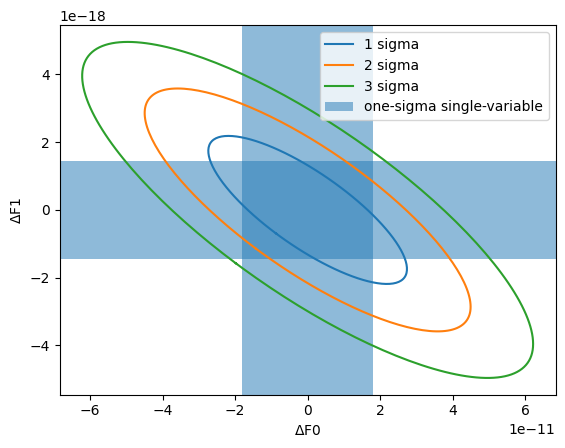

In [11]:
p1 = "F0"
p2 = "F1"
i = params.index(p1)
j = params.index(p2)
cor = np.array([[1, correlation[i, j]], [correlation[i, j], 1]])
sigmas = np.array([fitter.get_fitparams_uncertainty()[p] for p in [p1, p2]])
vals, vecs = scipy.linalg.eigh(cor)


def plot_ellipses():
    for n_sigma in [1, 2, 3]:
        thresh = np.sqrt(scipy.stats.chi2(2).isf(2 * scipy.stats.norm.cdf(-n_sigma)))
        angles = np.linspace(0, 2 * np.pi, 200)
        points = thresh * (
            np.sqrt(vals[0]) * np.cos(angles)[:, None] * vecs[None, :, 0]
            + np.sqrt(vals[1]) * np.sin(angles)[:, None] * vecs[None, :, 1]
        )
        plt.plot(
            points[:, 0] * sigmas[0], points[:, 1] * sigmas[1], label=f"{n_sigma} sigma"
        )

    plt.axvspan(-sigmas[0], sigmas[0], alpha=0.5, label="one-sigma single-variable")
    plt.axhspan(-sigmas[1], sigmas[1], alpha=0.5)

    plt.xlabel(r"$\Delta$" + f"{p1}")
    plt.ylabel(r"$\Delta$" + f"{p2}")


plot_ellipses()
plt.legend()

You can generate something like a posterior sample fairly easily:

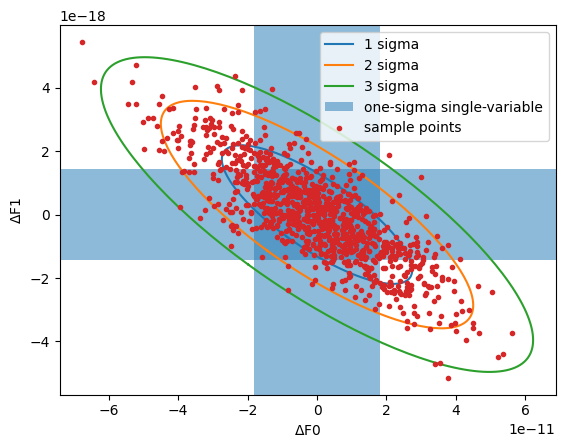

In [12]:
all_sigmas = np.array([fitter.get_fitparams_uncertainty()[p] for p in params])
sample = (
    scipy.stats.multivariate_normal(cov=correlation).rvs(size=1000)
    * all_sigmas[None, :]
)
plot_ellipses()
plt.plot(sample[:, i], sample[:, j], ".", label="sample points")
plt.legend()

## Model derivatives

PINT's fitters rely on having analytical derivatives of the timing model with respect to each parameter. These can be obtained by querying appropriate methods in the `TimingModel` object, but it is more conveniently packaged as the "design matrix" for the fit. Here too the order of the parameters may well not match what is in `fitter.model.free_params`.

In [13]:
design, names, units = fitter.get_designmatrix()
print(names)
print(units)
print(fitter.model.free_params)
print(design.shape)

['Offset', 'RAJ', 'DECJ', 'F0', 'F1', 'DM']
[Unit(dimensionless), Unit("1 / (Hz hourangle)"), Unit("1 / (Hz deg)"), Unit("1 / Hz2"), Unit("s / Hz2"), Unit("cm3 / (Hz pc)")]
['RAJ', 'DECJ', 'F0', 'F1', 'DM']
(62, 6)


Let's look at the derivatives (normalized so their scales are comparable) as a function of time. This may give us some hints for why the covariances are what they are.

Text(0, 0.5, 'Derivative (normalized)')

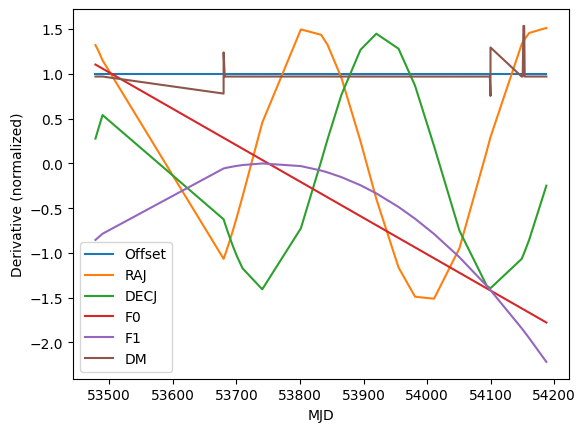

In [14]:
mjds = t.get_mjds()
ix = np.argsort(mjds)
assert np.all(np.diff(mjds[ix]) > 0)
for deriv, param in zip(design.T, names):
    deriv_normalized = deriv / np.sqrt((deriv**2).mean())
    plt.plot(mjds[ix], deriv_normalized[ix], label=param)
plt.legend()
plt.xlabel("MJD")
plt.ylabel("Derivative (normalized)")

We didn't actually include `Offset` in our covariance descriptions, but its covariance with DM is quite strong, and this plot shows why: we just don't have much frequency coverage, so the primary effect of changing DM is to change the absolute delay. Happily this isn't a covariance that need trouble us unless we want absolute phases.